In [1]:
from datetime import date, timedelta
from typing import List


from app.domain.simulation_engine.commands import RunSimulationCommand
from app.domain.simulation_engine.common.types import SimulationPortfolioWeights, CashFlow, AssetCosts, ExpectedReturns
from app.domain.simulation_engine.common.utils import convert_json_to_snake

from app.domain.domain_entities import Income, Expense, Asset, FinancialPlan, Portfolio

from app.common.enums import SimulationType, SimulationStepType, InterpolationMethod, AssetClass

from app.application.services.simulation_service import build_cash_flows, convert_portfolio_to_weights, build_simulation_data


c:\Users\olive\Documents\adviser backend\MonteCarloPlanner\venv\Lib\site-packages\pydantic\_internal\_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'validate_by_name'
* 'validate_all' has been renamed to 'validate_default'
  warnings.warn(message, UserWarning)


In [38]:
incomes = [
    Income(
        source="Salary", 
        amount=5000, 
        frequency="monthly", 
        start_date=date.today(), 
        end_date=date(2035, 12, 31)
    ),
    Income(
        source="Salary", 
        amount=6000, 
        frequency="monthly", 
        start_date=date.today(), 
        end_date=date(2065, 12, 31)
    )
]

expenses = [
    Expense(
        expense_name="Total Expenses", 
        amount=4500, 
        frequency="monthly", 
        start_date=date.today(), 
        end_date=date(2065, 12, 31)
    ),
    Expense(
        expense_name="Rent", 
        amount=4500, 
        frequency="monthly", 
        start_date=date(2066, 1, 1), 
        end_date=date(2090, 12, 31)
    )
]

portfolio_weights = [
    Portfolio(
        start_date=date(2025, 1, 1),
        end_date=date(2055, 12, 31),
        equity_weight=0.9
    ),
    Portfolio(
        start_date=date(2056, 1, 1),
        end_date=date(2090, 12, 31),
        equity_weight=0.4
    )
]

financial_plan = FinancialPlan(
    financial_plan_name="Default Financial Plan",
    start_date=date(2025, 1, 1),
    end_date=date(2090, 12, 31),
    initial_wealth=0.0,
    inflation=0.03,
    number_of_simulations=5000,
    step_size=SimulationStepType.ANNUAL,
    expected_returns = ExpectedReturns(cash=0.03, stocks=0.08, bonds=0.045),
    asset_costs = AssetCosts(cash=0.0005, stocks=0.003, bonds=0.004)
)


In [39]:
simulation_request = build_simulation_data(incomes, expenses, portfolio_weights, financial_plan)

In [40]:
simulation_request

{'number_of_simulations': 5000,
 'end_step': 65,
 'weights': [SimulationPortfolioWeights(step=0.0, stocks=0.9, bonds=0.0),
  SimulationPortfolioWeights(step=31.0, stocks=0.4, bonds=0.0)],
 'savings_rates': [CashFlow(step=0.0, value=78000.0),
  CashFlow(step=11.0, value=18000.0),
  CashFlow(step=41.0, value=-54000.0)],
 'oneoff_transactions': [],
 'inflation': 0.03,
 'initial_wealth': 0.0,
 'percentiles': [25, 50, 75],
 'simulation_type': <SimulationType.CHOLESKY: 'cholesky'>,
 'step_size': <SimulationStepType.ANNUAL: 'annual'>,
 'weights_interpolation': <InterpolationMethod.FFILL: 'ffill'>,
 'savings_rate_interpolation': <InterpolationMethod.FFILL: 'ffill'>,
 'asset_costs': AssetCosts(cash=0.0005, stocks=0.003, bonds=0.004),
 'asset_returns': ExpectedReturns(cash=0.03, stocks=0.08, bonds=0.045)}

In [41]:
command = RunSimulationCommand.model_validate(convert_json_to_snake(simulation_request))
result = command.handle()

   step  cashflow
0   0.0   78000.0
1  11.0   18000.0
2  41.0  -54000.0
      stocks  bonds  cash
step                     
0.0      0.9    0.0   0.1
31.0     0.4    0.0   0.6
Simulating...
destitution area 0.015676923076923074


c:\Users\olive\Documents\adviser backend\MonteCarloPlanner\app\domain\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


In [42]:
result

SimulationResultDTO(real=SimulationDataDTO(percentiles={25.0: [0.0, 78000.0, 150145.6379994813, 221820.9289898251, 294225.7515321043, 363225.8512131133, 436085.359719594, 509031.1750604779, 580244.3168767792, 651171.5650609353, 730848.2331462209, 740889.6129426772, 757406.6832456384, 780192.0926249829, 796289.1369505927, 815267.2070206327, 840948.7939779164, 848037.2525604444, 880859.707095891, 897883.0472391305, 920807.3053672148, 950066.0473921758, 979438.4176864992, 1006133.2877874505, 1041987.9573639855, 1072989.72226954, 1092949.0467795546, 1127912.8492320047, 1172385.817495456, 1198852.0941145688, 1227602.7405884417, 1262084.1562914727, 1295356.1972041123, 1335107.0064817693, 1367056.707898126, 1398167.0123507362, 1437697.0663080802, 1473279.1830827205, 1510178.8099321148, 1522622.112135857, 1571987.1055778814, 1529825.4772802964, 1483678.7284044384, 1452228.1627933804, 1420182.8542877133, 1375480.1648441937, 1338224.0512327265, 1290474.8306286007, 1249667.9474026915, 1225088.564

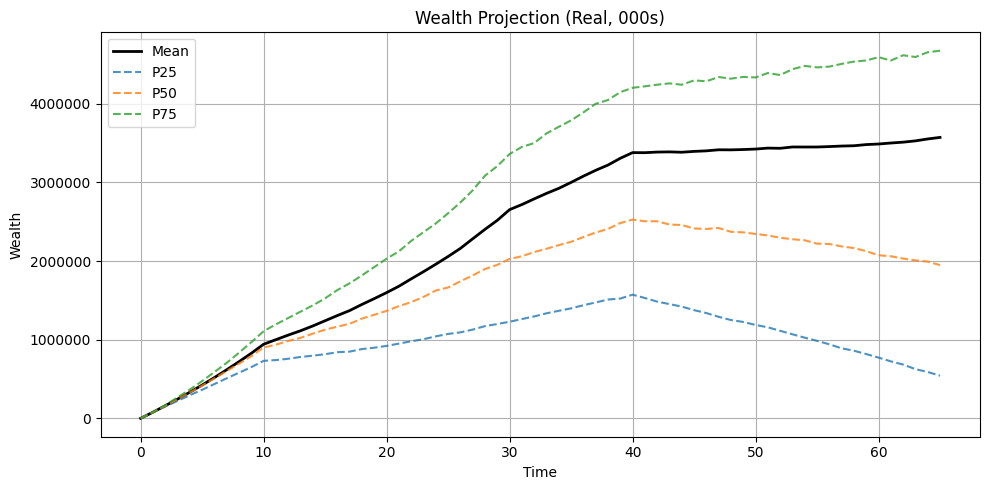

In [43]:
import matplotlib.pyplot as plt

def plot_simulation_series(result, use_real=True, percentiles=(5, 25, 50, 75, 95)):
    data = result.real if use_real else result.nominal
    x = result.timesteps
    plt.figure(figsize=(10, 5))

    # Mean
    plt.plot(x, data.mean, label="Mean", color="black", linewidth=2)

    # Percentiles
    for p in percentiles:
        y = data.percentiles.get(p) or data.percentiles.get(float(p))
        if y:
            plt.plot(x, y, label=f"P{int(p)}", linestyle="--", alpha=0.8)
    
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.xlabel("Time")
    plt.ylabel("Wealth")
    plt.title(f"Wealth Projection ({'Real, 000s' if use_real else 'Nominal, 000s'})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_simulation_series(result)

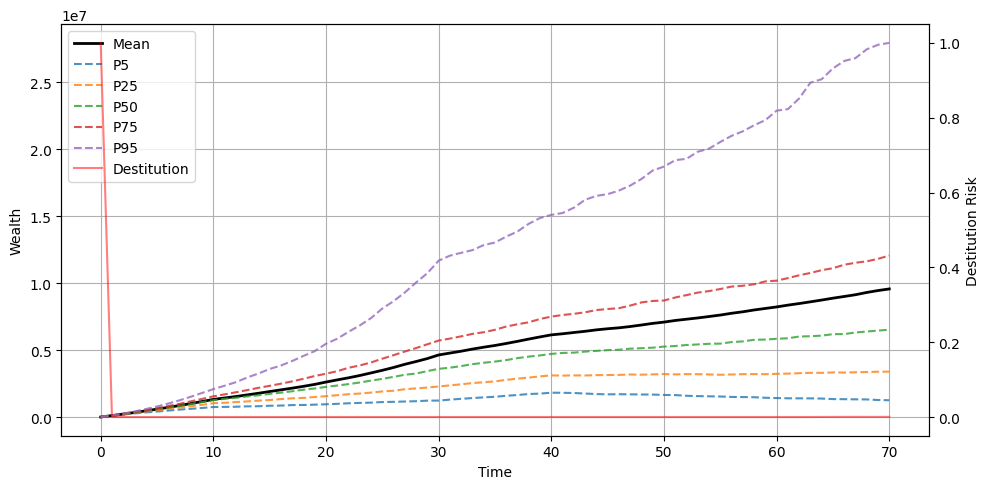

In [16]:
def plot_with_destitution(result, use_real=True, percentiles=(5, 50, 95)):
    data = result.real if use_real else result.nominal
    x = result.timesteps

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(x, data.mean, label="Mean", color="black", linewidth=2)
    for p in percentiles:
        y = data.percentiles.get(p) or data.percentiles.get(float(p))
        if y:
            ax1.plot(x, y, label=f"P{int(p)}", linestyle="--", alpha=0.8)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Wealth")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(x[:-1] if len(result.destitution)==len(x)-1 else x, result.destitution,
             color="red", alpha=0.5, label="Destitution")
    ax2.set_ylabel("Destitution Risk")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best")
    plt.tight_layout()
    plt.show()

plot_with_destitution(result, use_real=True, percentiles=(5, 25, 50, 75, 95))